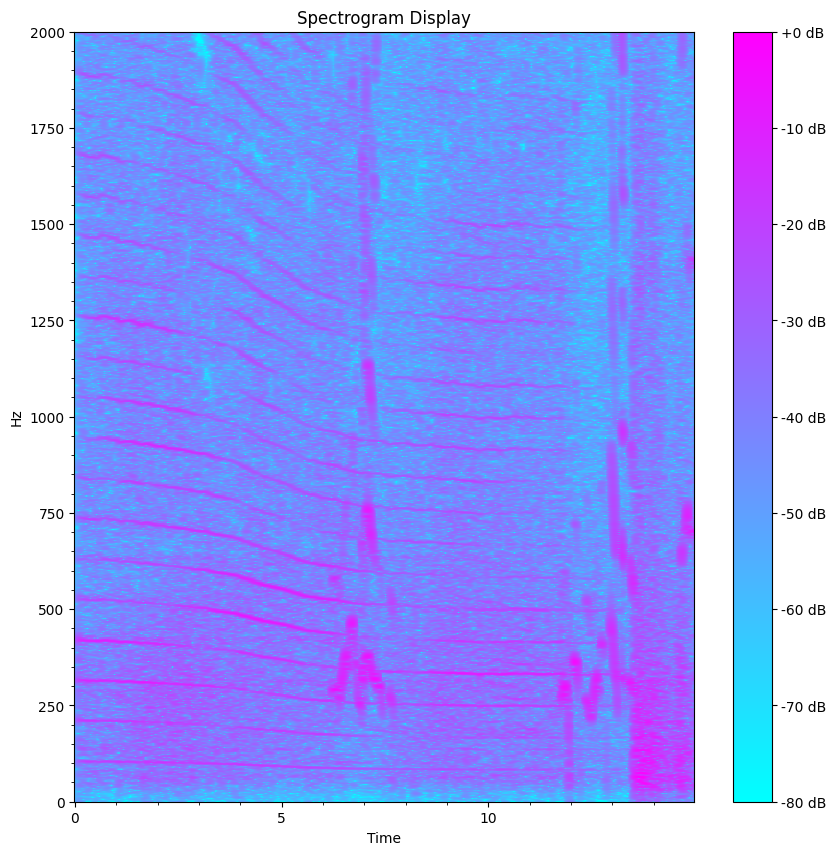

In [5]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd


# Load your WAV file
data, samplerate = librosa.load('twittervid.com_JoshBreiner_d7d7e9.wav', sr=44100)

start_time = 0  # Start time in seconds
end_time = 15  # End time in seconds
start_sample = int(start_time * samplerate)
end_sample = int(end_time * samplerate)
data_segment = data[start_sample:end_sample]

# Compute the spectrogram with a larger n_fft for finer frequency resolution
n_fft_value = 2**14  # Increase this value for finer frequency details
hop_length = 1024  # Defined hop length
D = librosa.stft(data_segment, n_fft=n_fft_value, hop_length=hop_length)
S_db = librosa.amplitude_to_db(abs(D), ref=np.max)

# Create the time vector for x-axis adjustment
times = np.arange(S_db.shape[1]) * hop_length / samplerate + start_time

# Plot the spectrogram
plt.figure(figsize=(10, 10))
librosa.display.specshow(S_db, sr=samplerate, x_coords=times, x_axis='time', y_axis='hz', cmap='cool')
plt.colorbar(format='%+2.0f dB')
plt.ylim(0, 2000)  # Adjust this value if you want to change the frequency range displayed
plt.title('Spectrogram Display')
plt.minorticks_on()
#plt.grid(which='both')
plt.show()


In [6]:

def analyze_audio_fft(file_name, f0, f1, num_peaks, t_seconds, segment_length, plot=False):
    # Load the WAV file
    data, samplerate = librosa.load(file_name, sr=44100)

    # Calculate the starting and ending samples for the segment
    start_sample = int(t_seconds * samplerate)
    end_sample = int((t_seconds + segment_length) * samplerate)
    segment = data[start_sample:end_sample]

    # Compute the FFT of the segment
    fft_result = np.fft.rfft(segment)
    frequencies = np.fft.rfftfreq(len(segment), d=1/samplerate)

    # Compute the magnitude of the FFT result (since FFT is complex)
    magnitude = np.abs(fft_result)

    # Find indices within the desired frequency range
    freq_indices = (frequencies >= f0) & (frequencies <= f1)

    # Find peaks within the specified frequency interval
    peaks, _ = find_peaks(magnitude[freq_indices], distance=20)
    actual_freqs = frequencies[freq_indices][peaks]
    actual_mags = magnitude[freq_indices][peaks]

    # Get the top N peaks within this range
    if len(actual_freqs) > num_peaks:
        top_indices = np.argsort(actual_mags)[-num_peaks:]  # Indices of the top N peaks
    else:
        top_indices = np.argsort(actual_mags)  # Use all if less than N

    top_freqs = actual_freqs[top_indices]
    top_mags = actual_mags[top_indices]

    # Optionally plot the FFT result with peak detection and annotations
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(frequencies, magnitude, label='Magnitude Spectrum')
        plt.scatter(top_freqs, top_mags, color='r', s=100, label='Top Peaks')
        for i in range(len(top_freqs)):
            plt.annotate(f'{top_freqs[i]:.0f} Hz',
                         (top_freqs[i], top_mags[i]), textcoords="offset points", xytext=(0,10), ha='center')
        plt.title(f'FFT Result and Top Peaks at {t_seconds} seconds')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.xlim(0, 2000)  # Limit the x-axis for better visibility of lower frequencies
        plt.grid(True)
        plt.legend()
        plt.show()

    return top_freqs, top_mags



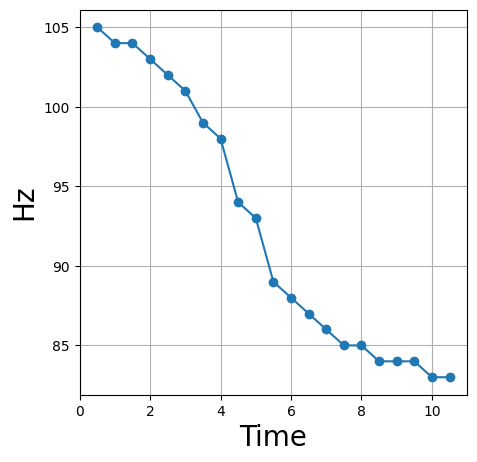

In [8]:
file_name = 'twittervid.com_JoshBreiner_d7d7e9.wav'
f0 = 0
f1 = 200
num_peaks = 1
plot = False
start = 0
stop = 10.5
length = 1
margin = 40
t = start
fs = list()
ts = list()
while t < stop:
    peaks, magnitudes = analyze_audio_fft(file_name, f0, f1, num_peaks, t, length, plot)
    f0 = peaks[0] - margin
    f1 = peaks[0] + margin
    t += length/2
    #print (peaks[0])
    ts.append(t)
    fs.append(peaks[0])

#a bit ugly code - I wanted to add the last frequency data point but skip the Russian talking that confused my simple algorithm
fs.append(peaks[0]) 
ts.append(13.7)



df = pd.DataFrame({'t': ts, 'f': fs})
fig, ax = plt.subplots(figsize = [5,5])
ax.plot(df.t, df.f,marker = 'o')
ax.set_ylabel('Hz',fontsize= 20)
ax.set_xlabel('Time', fontsize = 20)
ax.grid('both')

In [12]:
f1 = 93  # Original frequency in Hz
c = 343  # Speed of sound in m/s at 20 degrees Celsius

df['v'] = c * (1 - f1/df.f)
display(df)


,t,f,v
0,0.5,105.0,39.200000
1,1.0,104.0,36.278846
2,1.5,104.0,36.278846
3,2.0,103.0,33.300971
4,2.5,102.0,30.264706
5,3.0,101.0,27.168317
6,3.5,99.0,20.787879
7,4.0,98.0,17.500000
8,4.5,94.0,3.648936
9,5.0,93.0,0.000000


In [13]:
# Data setup
times = df.t
frequencies = df.f

# Constants
c = 343.0  # Speed of sound (m/s)
f0 = 93.0  # Reference frequency at closest approach (Hz)

# Calculate radial velocities
v_r = c * (1 - f0 / frequencies)

# Known final distance
final_distance = 430  # meters at t = 10.5 seconds
final_index = np.where(times == 13.7)[0][0]

# Initialize distance array
distances = np.zeros_like(times)
distances[final_index] = final_distance

# Integrate backward from the final point to the minimum
for i in range(final_index, 0, -1):
    dt = times[i] - times[i - 1]
    distances[i - 1] = distances[i] + v_r[i] * dt

# Integrate forward from the minimum to the start
for i in range(final_index, len(times) - 1):
    dt = times[i + 1] - times[i]
    distances[i + 1] = distances[i] - v_r[i] * dt

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(times, distances, 'o-', label='Distance')
plt.axvline(x=5, color='r', linestyle='--', label='Closest Approach')
plt.title('Distance from Observer Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Distance (meters)')
plt.legend()
plt.grid(True)
plt.minorticks_on()

plt.show()


IndexError: index 0 is out of bounds for axis 0 with size 0